# CNN Model

This notebook contains the construction and the evaluations of CNN models for colorization purposes.

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from utils.dataset import CocoDataset
from utils.plots import plot_l, plot_a, plot_b, plot_rgb, reconstruct_lab, plot_predicted_image, plot_ab
from utils.models import BaselineCNN, save_model, load_model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data import

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # tensorization brings image in range [0,1] and space CxHxW
])

In [4]:
path_sandro = "coco/images/train2014"
path_diego = "C:/Users/diego/coco/images/train2014/train2014"
dataset = CocoDataset(root=path_sandro, transform=transform)

Found 82783 images.


## Data preparation

We split our dataset in train and test data.

In [5]:
torch.manual_seed(42)
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train, test = random_split(dataset, [train_size, test_size], torch.Generator().manual_seed(42))
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size], torch.Generator().manual_seed(42))
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size], torch.Generator().manual_seed(42))
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=True)

## CNN Model

We will now build a network of 9 convolutional layers, each followed by a ReLU activation and a BatchNorm layer, with vanishing learning rate.

### Training

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, stride=1, padding=2),  # Conv1
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.Conv2d(4, 8, kernel_size=5, stride=1, padding=2),  # Conv2
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),  # Conv3
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),  # Conv4
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),  # Conv5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),  # Conv6
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 32, kernel_size=5, stride=1, padding=2),  # Conv7
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 8, kernel_size=5, stride=1, padding=2),  # Conv8
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 1, kernel_size=5, stride=1, padding=2),  # Conv9
            nn.ReLU(),
            nn.BatchNorm2d(1),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1 * 64 * 64, 2 * 64 * 64)  # Assuming the input size 64x64, adjust accordingly

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = x.view(-1, 2, 64, 64)  # Reshape back to expected output dimensions
        return x

### MSE Loss

In [ ]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [8]:
NUM_EPOCHS = 15
train_losses = []
test_losses = []
criterion1 = nn.MSELoss()

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss = 0.0

    # Training loop
    model.train()
    for _, l_channels, _, _, ab_channels in tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True):
        l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)

        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion1(outputs, ab_channels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # scheduler.step()  # Update the scheduler
    train_losses.append(running_loss / len(train_loader))

    # Testing loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)
            outputs = model(l_channels)
            loss = criterion1(outputs, ab_channels)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))

    # Print training and validation losses
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {test_losses[-1]}")

print('Finished Training')

Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 1, Train Loss: 0.00481525463083588, Validation Loss: 0.00048822691146298725


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 2, Train Loss: 0.0004135463649973921, Validation Loss: 0.0002887329090257179


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 3, Train Loss: 0.00032480007424446695, Validation Loss: 0.0002648757598057217


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 4, Train Loss: 0.00031209470375760456, Validation Loss: 0.0002252195231817864


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 5, Train Loss: 0.00028046707753182033, Validation Loss: 0.00021467291081187577


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 6, Train Loss: 0.00027116574886916343, Validation Loss: 0.00020907056323723675


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 7, Train Loss: 0.0002627557109825421, Validation Loss: 0.0002206344423549516


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 8, Train Loss: 0.0002604494046797787, Validation Loss: 0.00021733402662899734


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 9, Train Loss: 0.00025714103825354346, Validation Loss: 0.00021716690366965462


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 10, Train Loss: 0.00025372772931980624, Validation Loss: 0.00022181967618555175


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 11, Train Loss: 0.0002512086189581432, Validation Loss: 0.00020260489401928937


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 12, Train Loss: 0.00025646185506909077, Validation Loss: 0.00020169927450939726


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 13, Train Loss: 0.00024419581351108884, Validation Loss: 0.00020631585219824637


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 14, Train Loss: 0.00025501407363456516, Validation Loss: 0.0002166867907011601


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]

Epoch 15, Train Loss: 0.00024624947134567346, Validation Loss: 0.00021262103997343526
Finished Training


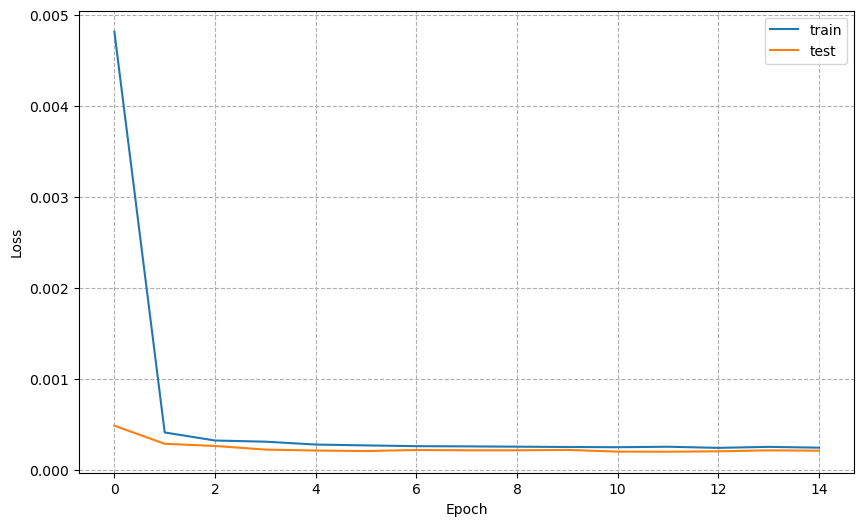

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

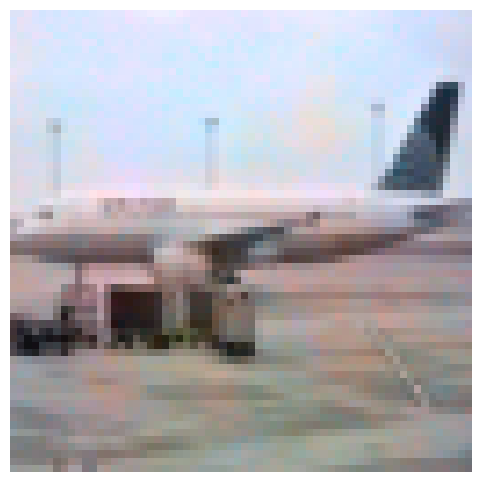

In [13]:
input = dataset[7653][1].to(device).unsqueeze(0)
ab = model(input).squeeze(0)
reconstruct_lab(dataset[7653][1].to(device).detach().cpu(), ab.detach().cpu())

In [14]:
save_model(model, "CNN_MSELoss")

Model saved to models\CNN_MSELoss.pth successfully!


In [15]:
loaded_model1 = load_model(CNN(), "models/CNN_MSELoss.pth").to(device)

CNN model loaded successfully!


In [16]:
next(loaded_model1.parameters()).device # check model is on the right device

device(type='cuda', index=0)

In [17]:
loaded_model1.eval()

total_mse = 0
total_psnr = 0
num_samples = 0

with torch.no_grad():
    for _, l_channels, _, _, ab_channels in small_test_loader:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)

        ab_preds = loaded_model1(l_channels)

        mse = F.mse_loss(ab_preds, ab_channels)
        total_mse += mse.item() * ab_channels.size(0)

        max_pixel_value = 1.0  # image values are between 0 and 1
        psnr = 20 * torch.log10(max_pixel_value**2 / mse)
        total_psnr += psnr.item() * ab_channels.size(0)

        num_samples += ab_channels.size(0)

avg_mse = total_mse / num_samples
avg_psnr = total_psnr / num_samples

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")

Average MSE: 0.0034
Average PSNR: 49.3338


### L1 Loss

In [18]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [19]:
train_losses = []
test_losses = []
criterion2 = nn.L1Loss()

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss = 0.0

    # Training loop
    model.train()
    for _, l_channels, _, _, ab_channels in tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True):
        l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)

        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion2(outputs, ab_channels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # scheduler.step()  # Update the scheduler
    train_losses.append(running_loss / len(train_loader))

    # Testing loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)
            outputs = model(l_channels)
            loss = criterion2(outputs, ab_channels)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))

    # Print training and validation losses
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {test_losses[-1]}")

print('Finished Training')

Testing: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 1, Train Loss: 0.011981936144656029, Validation Loss: 0.002999647329903017


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 2, Train Loss: 0.0032510365372982577, Validation Loss: 0.0028100700682194535


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]


Epoch 3, Train Loss: 0.003124218945198013, Validation Loss: 0.0025428506513359922


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 4, Train Loss: 0.003054009129603704, Validation Loss: 0.00280413225753427


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.20it/s]


Epoch 5, Train Loss: 0.0030495289119257443, Validation Loss: 0.0025053273699458503


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 6, Train Loss: 0.0029821502737664945, Validation Loss: 0.002541261131814088


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]


Epoch 7, Train Loss: 0.0029855910166738113, Validation Loss: 0.0025354169568039737


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 8, Train Loss: 0.0029595232636168384, Validation Loss: 0.0024989851710879203


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 9, Train Loss: 0.00296559759600151, Validation Loss: 0.0024653483455475693


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 10, Train Loss: 0.0029387169450089553, Validation Loss: 0.0024582021600031024


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]


Epoch 11, Train Loss: 0.002921632315585579, Validation Loss: 0.002423248307700323


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 12, Train Loss: 0.0029304646135528307, Validation Loss: 0.002439602605394415


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 13, Train Loss: 0.002906317576981973, Validation Loss: 0.002441161517125759


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 14, Train Loss: 0.0029164071100345555, Validation Loss: 0.0024109671618717517


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]

Epoch 15, Train Loss: 0.0029068950041768633, Validation Loss: 0.002486893008229355
Finished Training


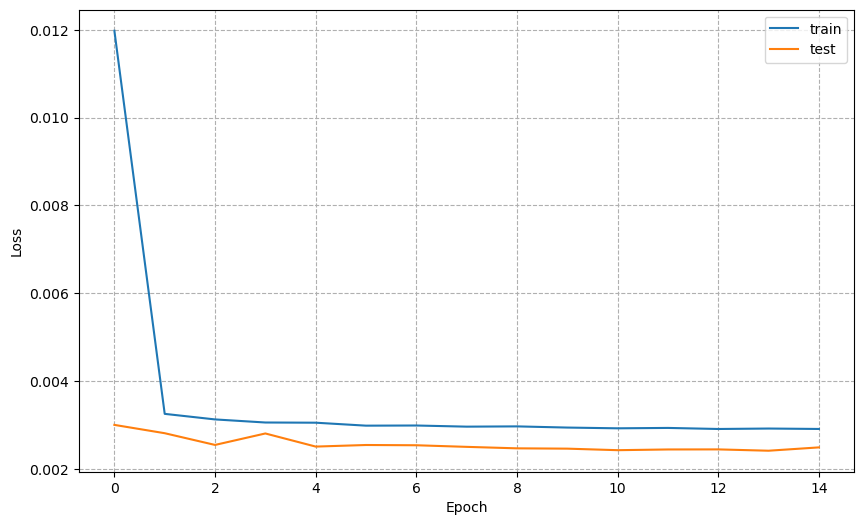

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

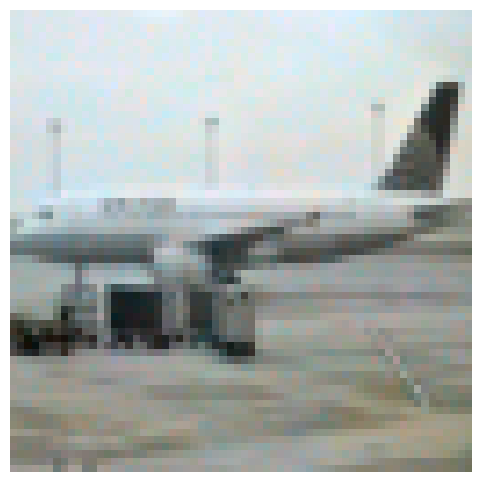

In [21]:
input = dataset[7653][1].to(device).unsqueeze(0)
ab = model(input).squeeze(0)
reconstruct_lab(dataset[7653][1].to(device).detach().cpu(), ab.detach().cpu())

In [22]:
save_model(model, "CNN_L1Loss")

Model saved to models\CNN_L1Loss.pth successfully!


In [23]:
loaded_model2 = load_model(CNN(), "models/CNN_L1Loss.pth").to(device)

CNN model loaded successfully!


In [24]:
next(loaded_model2.parameters()).device # check model is on the right device

device(type='cuda', index=0)

In [25]:
loaded_model2.eval()

total_mse = 0
total_psnr = 0
num_samples = 0

with torch.no_grad():
    for _, l_channels, _, _, ab_channels in small_test_loader:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)

        ab_preds = loaded_model2(l_channels)

        mse = F.mse_loss(ab_preds, ab_channels)
        total_mse += mse.item() * ab_channels.size(0)

        max_pixel_value = 1.0  # image values are between 0 and 1
        psnr = 20 * torch.log10(max_pixel_value**2 / mse)
        total_psnr += psnr.item() * ab_channels.size(0)

        num_samples += ab_channels.size(0)

avg_mse = total_mse / num_samples
avg_psnr = total_psnr / num_samples

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")

Average MSE: 0.0035
Average PSNR: 49.0605


### Smooth L1 loss

In [26]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [27]:
train_losses = []
test_losses = []
criterion3 = nn.SmoothL1Loss()

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss = 0.0

    # Training loop
    model.train()
    for _, l_channels, _, _, ab_channels in tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True):
        l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)

        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion3(outputs, ab_channels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # scheduler.step()  # Update the scheduler
    train_losses.append(running_loss / len(train_loader))

    # Testing loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)
            outputs = model(l_channels)
            loss = criterion3(outputs, ab_channels)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))

    # Print training and validation losses
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {test_losses[-1]}")

print('Finished Training')

Testing: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 1, Train Loss: 0.0019357605155665373, Validation Loss: 0.00013215069543987397


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 2, Train Loss: 0.0001518623546836673, Validation Loss: 0.00011370987874099762


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 3, Train Loss: 0.0001350751446991943, Validation Loss: 0.00010865153591993578


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 4, Train Loss: 0.00013097182381898164, Validation Loss: 0.00011336024667219076


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 5, Train Loss: 0.00012919378561386164, Validation Loss: 0.00010711588477895642


Testing: 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Epoch 6, Train Loss: 0.00012713790599004802, Validation Loss: 0.00010596695230216594


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 7, Train Loss: 0.0001265801218279822, Validation Loss: 0.00010238943305082302


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 8, Train Loss: 0.0001258994522954423, Validation Loss: 0.0001072131549493629


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


Epoch 9, Train Loss: 0.00012644930081307025, Validation Loss: 0.00010582516742978087


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 10, Train Loss: 0.0001254412075639635, Validation Loss: 0.0001087838111438116


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


Epoch 11, Train Loss: 0.00012427595138081893, Validation Loss: 0.00010237502496919691


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 12, Train Loss: 0.00012330207287599356, Validation Loss: 0.00010734392306677508


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 13, Train Loss: 0.00012348810422283728, Validation Loss: 0.00011419419165067806


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 14, Train Loss: 0.0001231421408319963, Validation Loss: 0.00010254356513900186


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]

Epoch 15, Train Loss: 0.0001232812482557723, Validation Loss: 0.00010323472650052843
Finished Training


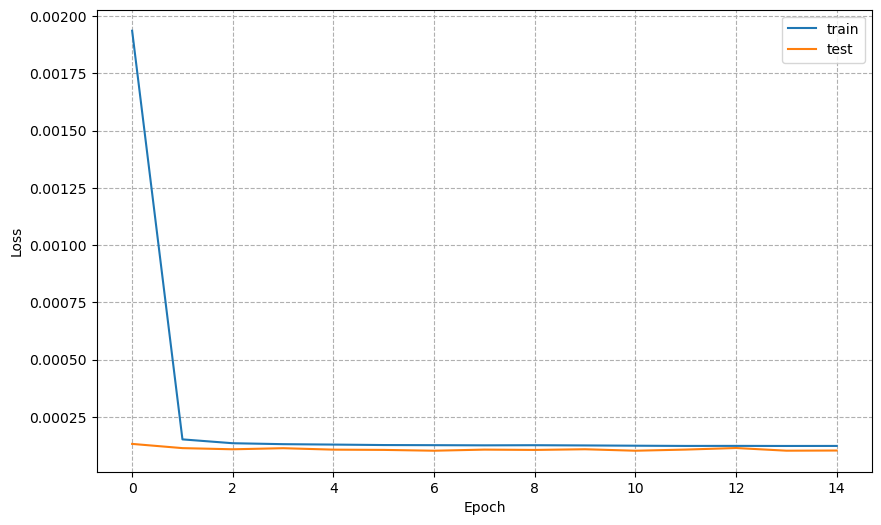

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

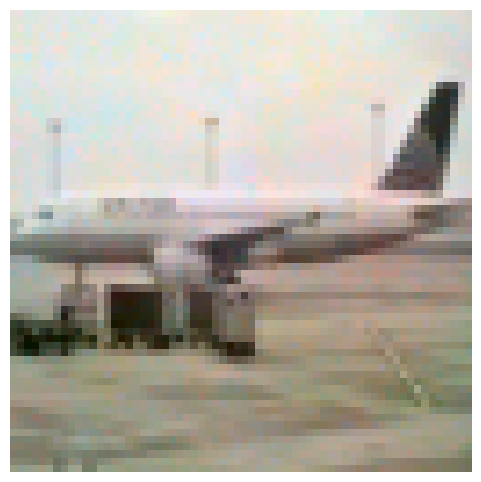

In [29]:
input = dataset[7653][1].to(device).unsqueeze(0)
ab = model(input).squeeze(0)
reconstruct_lab(dataset[7653][1].to(device).detach().cpu(), ab.detach().cpu())

In [30]:
save_model(model, "CNN_SmoothL1")

Model saved to models\CNN_SmoothL1.pth successfully!


In [31]:
loaded_model3 = load_model(CNN(), "models/CNN_SmoothL1.pth").to(device)

CNN model loaded successfully!


In [32]:
next(loaded_model3.parameters()).device # check model is on the right device

device(type='cuda', index=0)

In [33]:
loaded_model3.eval()

total_mse = 0
total_psnr = 0
num_samples = 0

with torch.no_grad():
    for _, l_channels, _, _, ab_channels in small_test_loader:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)

        ab_preds = loaded_model3(l_channels)

        mse = F.mse_loss(ab_preds, ab_channels)
        total_mse += mse.item() * ab_channels.size(0)

        max_pixel_value = 1.0  # image values are between 0 and 1
        psnr = 20 * torch.log10(max_pixel_value**2 / mse)
        total_psnr += psnr.item() * ab_channels.size(0)

        num_samples += ab_channels.size(0)

avg_mse = total_mse / num_samples
avg_psnr = total_psnr / num_samples

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")

Average MSE: 0.0033
Average PSNR: 49.5933


## Eval

In [ ]:
# plot_rgb(img[0])
# reconstruct_lab(img[1].detach().cpu(), loaded_model1(img[1].to(device)).detach().cpu())
# reconstruct_lab(img[1].detach().cpu(), loaded_model2(img[1].to(device)).detach().cpu())
# reconstruct_lab(img[1].detach().cpu(), loaded_model3(img[1].to(device)).detach().cpu())